# Linear Regression

Linear Regression is one of the most popular Regression algorithms. It can provide very good predictions if the data are well prepared. Its optimization function computes coefficients to express a response column as a linear relationship of its predictors. 

Linear Regression algorithm verifies the Gauss Markov assumptions.
 - <b>Linearity</b> : the parameters we are estimating using the OLS method must be themselves linear.
 - <b>Non-Collinearity</b> : the regressors being calculated aren’t perfectly correlated with each other.
 - <b>Exogeneity</b> : the regressors aren’t correlated with the error term.
 - <b>Homoscedasticity</b> : no matter what the values of our regressors might be, the error of the variance is constant.

That's why it is important to verify the hypothesis to compute a good Linear Regression.

To avoid unexpected results, there are many steps to follow.
 - Impute missing values (Linear Regression can not deal with missing values)
 - Encode categorical features (Linear Regression only accept numerical variables)
 - Computes the Correlation Matrix to retrieve highly correlated predictors
 - Decompose the data (Optional)
 - Normalize the data (Optional but very recommended)

# Example without Decomposition

Let's use the Africa dataset to compute a Linear Regression Model of the students school score.

In [1]:
from vertica_ml_python import *
africa = vDataFrame("africa_education")
africa = africa.select(["(zralocp + zmalocp) / 2 AS student_score",
                        "(zraloct + zmaloct) / 2 AS teacher_score",
                        "XNUMYRS AS teacher_year_teaching",
                        "numstu AS number_students_school",
                        "PENGLISH AS english_at_home",
                        "PTRAVEL AS travel_distance",
                        "PTRAVEL2 AS means_of_travel",
                        "PMOTHER AS m_education",
                        "PFATHER AS f_education",
                        "PLIGHT AS source_of_lighting",
                        "PABSENT AS days_absent",
                        "PREPEAT AS repeated_grades",
                        "zpsit AS sitting_place",
                        "PAGE AS age",
                        "zpses AS socio_eco_statut",
                        "country_long AS country"],
                        check = False)
print(africa)

,student_score,teacher_score,teacher_year_teaching,number_students_school,english_at_home,travel_distance,means_of_travel,m_education,f_education,source_of_lighting,days_absent,repeated_grades,sitting_place,age,socio_eco_statut,country
0,681.138508424325,None,26.0,24,ALL THE TIME,>0.5-1KM,CAR,Completed Some University,Completed Some University,ELECTRIC,0,NEVER,I have my own sitting place,12,15.0,South Africa
1,425.993367323877,537.289572911762,10.0,23,SOMETIMES,>4.5-5KM,WALK,I Do Not Know,I Do Not Know,PARAFFIN/OIL,0,NEVER,I have my own sitting place,14,5.0,Namibia
2,534.329515370892,537.289572911762,10.0,23,SOMETIMES,>0.5-1KM,WALK,Completed Some Primary,Completed All Primary,ELECTRIC,0,NEVER,I have my own sitting place,13,7.0,Namibia
3,536.690743411639,537.289572911762,10.0,23,SOMETIMES,UP TO 0.5KM,WALK,Completed Some Secondary,I Do Not Know,ELECTRIC,0,NEVER,I have my own sitting place,12,8.0,Namibia
4,569.392927563969,537.289572911762,10.0,23,SOMETIMES,UP TO 0.5KM,WALK,Completed Some Secondary,Completed Some Secondary,ELECTRIC,0,NEVER,I have my own sitting place,13,9.0,Namibia
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: africa_education, Number of rows: 60890, Number of columns: 16


We considered only some variables which might be interesting for the study. 

First, let's look at the missing values.

In [2]:
africa.count()

,count,percent
"""number_students_school""",60890.0,100.0
"""english_at_home""",60890.0,100.0
"""travel_distance""",60890.0,100.0
"""means_of_travel""",60890.0,100.0
"""m_education""",60890.0,100.0
"""source_of_lighting""",60890.0,100.0
"""days_absent""",60890.0,100.0
"""repeated_grades""",60890.0,100.0
"""sitting_place""",60890.0,100.0
"""age""",60890.0,100.0


<object>

As it is just an example and to avoid adding bias to the data, we will drop the missing values.

In [3]:
africa.dropna()

9089 element(s) was/were dropped


,student_score,teacher_score,teacher_year_teaching,number_students_school,english_at_home,travel_distance,means_of_travel,m_education,f_education,source_of_lighting,days_absent,repeated_grades,sitting_place,age,socio_eco_statut,country
0,425.993367323877,537.289572911762,10.0,23,SOMETIMES,>4.5-5KM,WALK,I Do Not Know,I Do Not Know,PARAFFIN/OIL,0,NEVER,I have my own sitting place,14,5.0,Namibia
1,534.329515370892,537.289572911762,10.0,23,SOMETIMES,>0.5-1KM,WALK,Completed Some Primary,Completed All Primary,ELECTRIC,0,NEVER,I have my own sitting place,13,7.0,Namibia
2,536.690743411639,537.289572911762,10.0,23,SOMETIMES,UP TO 0.5KM,WALK,Completed Some Secondary,I Do Not Know,ELECTRIC,0,NEVER,I have my own sitting place,12,8.0,Namibia
3,569.392927563969,537.289572911762,10.0,23,SOMETIMES,UP TO 0.5KM,WALK,Completed Some Secondary,Completed Some Secondary,ELECTRIC,0,NEVER,I have my own sitting place,13,9.0,Namibia
4,542.037992351316,537.289572911762,10.0,23,MOST OF THE TIME,UP TO 0.5KM,WALK,Completed Some University,Completed Some Primary,ELECTRIC,0,NEVER,I have my own sitting place,12,11.0,Namibia
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: africa_education, Number of rows: 51801, Number of columns: 16

We need to encode the categorical columns to dummies to keep the linearity of the process.

In [4]:
africa.get_dummies(max_cardinality = 20)

,student_score,teacher_score,teacher_year_teaching,number_students_school,english_at_home,travel_distance,means_of_travel,m_education,f_education,source_of_lighting,days_absent,repeated_grades,sitting_place,age,socio_eco_statut,country,english_at_home_ALL_THE_TIME,english_at_home_MOST_OF_THE_TIME,english_at_home_NEVER,travel_distance_>0.5-1KM,travel_distance_>1-1.5KM,travel_distance_>1.5-2KM,travel_distance_>2-2.5KM,travel_distance_>2.5-3KM,travel_distance_>3-3.5KM,travel_distance_>3.5-4KM,travel_distance_>4.5-5KM,travel_distance_>4KM-4.5KM,travel_distance_>5KM,means_of_travel_BICYCLE,means_of_travel_BUS_TRUCK_VAN,means_of_travel_CAR,means_of_travel_OTHER,means_of_travel_TRAIN,m_education_Completed_All_Primary,m_education_Completed_All_Secondary,m_education_Completed_Some_Primary,m_education_Completed_Some_Secondary,m_education_Completed_Some_University,m_education_Completed_Training_After_Secondary,m_education_Completed_University_Degree,m_education_I_Do_Not_Have_a_Mother,m_education_I_Do_Not_Know,m_education_No_School__No_Adult_Education,m_education_No_School__Some_Adult_Education,f_education_Completed_All_Primary,f_education_Completed_All_Secondary,f_education_Completed_Some_Primary,f_education_Completed_Some_Secondary,f_education_Completed_Some_University,f_education_Completed_Training_After_Secondary,f_education_Completed_University_Degree,f_education_I_Do_Not_Have_a_Father,f_education_I_Do_Not_Know,f_education_No_School__No_Adult_Education,f_education_No_School__Some_Adult_Education,source_of_lighting_CANDLE,source_of_lighting_ELECTRIC,source_of_lighting_FIRE,source_of_lighting_GAS,source_of_lighting_NO_LIGHTING,repeated_grades_NEVER,repeated_grades_ONCE,repeated_grades_THREE_PLUS,sitting_place_I_have_my_own_sitting_place,age_10,age_11,age_12,age_13,age_14,age_15,age_16,age_17,age_18,age_19,age_20,age_21,age_22,age_23,age_24,age_25,socio_eco_statut_1.0,socio_eco_statut_2.0,socio_eco_statut_3.0,socio_eco_statut_4.0,socio_eco_statut_5.0,socio_eco_statut_6.0,socio_eco_statut_7.0,socio_eco_statut_8.0,socio_eco_statut_9.0,socio_eco_statut_10.0,socio_eco_statut_11.0,socio_eco_statut_12.0,socio_eco_statut_13.0,socio_eco_statut_14.0,country_Botswana,country_Kenya,country_Lesotho,country_Malawi,country_Mozambique,country_Namibia,country_Seychelles,country_South_Africa,country_Swaziland,country_Tanzania,country_Uganda,country_Zambia,country_Zanzibar
0,425.993367323877,537.289572911762,10.0,23,SOMETIMES,>4.5-5KM,WALK,I Do Not Know,I Do Not Know,PARAFFIN/OIL,0,NEVER,I have my own sitting place,14,5.0,Namibia,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,534.329515370892,537.289572911762,10.0,23,SOMETIMES,>0.5-1KM,WALK,Completed Some Primary,Completed All Primary,ELECTRIC,0,NEVER,I have my own sitting place,13,7.0,Namibia,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,536.690743411639,537.289572911762,10.0,23,SOMETIMES,UP TO 0.5KM,WALK,Completed Some Secondary,I Do Not Know,ELECTRIC,0,NEVER,I have my own sitting place,12,8.0,Namibia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,569.392927563969,537.289572911762,10.0,23,SOMETIMES,UP TO 0.5KM,WALK,Completed Some Secondary,Completed Some Secondary,ELECTRIC,0,NEVER,I have my own sitting place,13,9.0,Namibia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,542.037992351316,537.289572911762,10.0,23,MOST OF THE TIME,UP TO 0.5KM,WALK,Completed Some University,Completed Some Primary,ELECTRIC,0,NEVER,I have my own sitting place,12,11.0,Namibia,0,1,

<object>  Name: africa_education, Number of rows: 51801, Number of columns: 108

We can drop the categorical columns as Linear Regression can not handle them.

In [5]:
africa.drop(columns = ["english_at_home",
                       "travel_distance",
                       "means_of_travel",
                       "m_education",
                       "f_education",
                       "source_of_lighting",
                       "repeated_grades",
                       "sitting_place",
                       "country"])

,student_score,teacher_score,teacher_year_teaching,number_students_school,days_absent,age,socio_eco_statut,english_at_home_ALL_THE_TIME,english_at_home_MOST_OF_THE_TIME,english_at_home_NEVER,travel_distance_>0.5-1KM,travel_distance_>1-1.5KM,travel_distance_>1.5-2KM,travel_distance_>2-2.5KM,travel_distance_>2.5-3KM,travel_distance_>3-3.5KM,travel_distance_>3.5-4KM,travel_distance_>4.5-5KM,travel_distance_>4KM-4.5KM,travel_distance_>5KM,means_of_travel_BICYCLE,means_of_travel_BUS_TRUCK_VAN,means_of_travel_CAR,means_of_travel_OTHER,means_of_travel_TRAIN,m_education_Completed_All_Primary,m_education_Completed_All_Secondary,m_education_Completed_Some_Primary,m_education_Completed_Some_Secondary,m_education_Completed_Some_University,m_education_Completed_Training_After_Secondary,m_education_Completed_University_Degree,m_education_I_Do_Not_Have_a_Mother,m_education_I_Do_Not_Know,m_education_No_School__No_Adult_Education,m_education_No_School__Some_Adult_Education,f_education_Completed_All_Primary,f_education_Completed_All_Secondary,f_education_Completed_Some_Primary,f_education_Completed_Some_Secondary,f_education_Completed_Some_University,f_education_Completed_Training_After_Secondary,f_education_Completed_University_Degree,f_education_I_Do_Not_Have_a_Father,f_education_I_Do_Not_Know,f_education_No_School__No_Adult_Education,f_education_No_School__Some_Adult_Education,source_of_lighting_CANDLE,source_of_lighting_ELECTRIC,source_of_lighting_FIRE,source_of_lighting_GAS,source_of_lighting_NO_LIGHTING,repeated_grades_NEVER,repeated_grades_ONCE,repeated_grades_THREE_PLUS,sitting_place_I_have_my_own_sitting_place,age_10,age_11,age_12,age_13,age_14,age_15,age_16,age_17,age_18,age_19,age_20,age_21,age_22,age_23,age_24,age_25,socio_eco_statut_1.0,socio_eco_statut_2.0,socio_eco_statut_3.0,socio_eco_statut_4.0,socio_eco_statut_5.0,socio_eco_statut_6.0,socio_eco_statut_7.0,socio_eco_statut_8.0,socio_eco_statut_9.0,socio_eco_statut_10.0,socio_eco_statut_11.0,socio_eco_statut_12.0,socio_eco_statut_13.0,socio_eco_statut_14.0,country_Botswana,country_Kenya,country_Lesotho,country_Malawi,country_Mozambique,country_Namibia,country_Seychelles,country_South_Africa,country_Swaziland,country_Tanzania,country_Uganda,country_Zambia,country_Zanzibar
0,425.993367323877,537.289572911762,10.0,23,0,14,5.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,534.329515370892,537.289572911762,10.0,23,0,13,7.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,536.690743411639,537.289572911762,10.0,23,0,12,8.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,569.392927563969,537.289572911762,10.0,23,0,13,9.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,542.037992351316,537.289572911762,10.0,23,0,12,11.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: africa_education, Number of rows: 51801, Number of columns: 99

Let's look at the correlation between the response column and the predictors and keep only the ones that are correlated with coefficients greater than 20% (top 10 features).

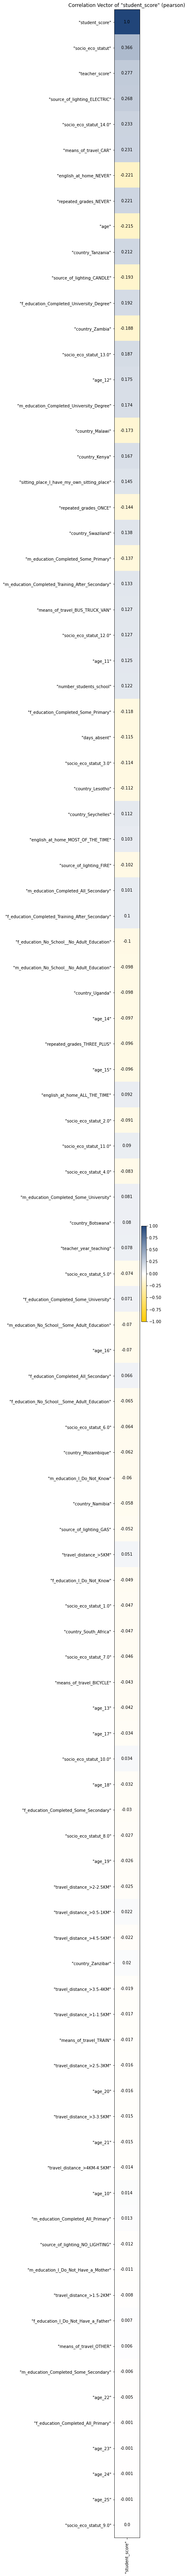

,student_score,socio_eco_statut,teacher_score,source_of_lighting_ELECTRIC,socio_eco_statut_14.0,means_of_travel_CAR,english_at_home_NEVER,repeated_grades_NEVER,age,country_Tanzania,source_of_lighting_CANDLE,f_education_Completed_University_Degree
0,425.993367323877,5.0,537.289572911762,0,0,0,0,1,14,0,0,0
1,534.329515370892,7.0,537.289572911762,1,0,0,0,1,13,0,0,0
2,536.690743411639,8.0,537.289572911762,1,0,0,0,1,12,0,0,0
3,569.392927563969,9.0,537.289572911762,1,0,0,0,1,13,0,0,0
4,542.037992351316,11.0,537.289572911762,1,0,0,0,1,12,0,0,0
,...,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: africa_education, Number of rows: 51801, Number of columns: 12


In [16]:
x = africa.corr(focus = "student_score")
africa = africa.select(columns = x.values["index"][0:12])
print(africa)

Let's now look at the correlation matrix to see if we have independant predictors.

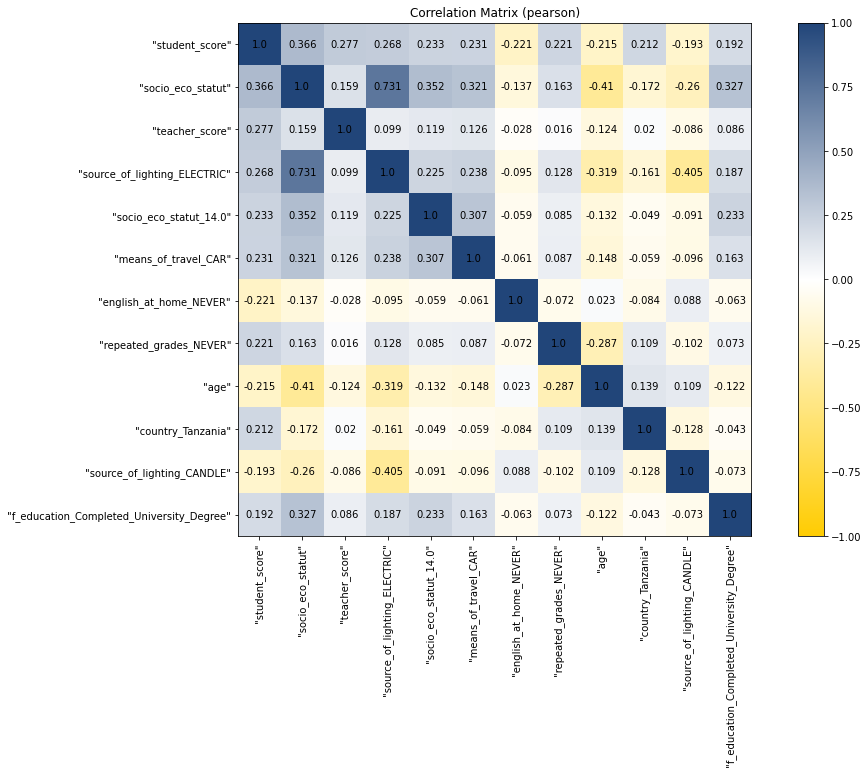

In [17]:
x = africa.corr()

Some of them are highly correlated (Example: Socio Economical Statut and Electric Source of Lighting), it is possible to drop one of them to avoid unexpected result during the Linear Regression computation.

In [18]:
africa["source_of_lighting_ELECTRIC"].drop()

,student_score,socio_eco_statut,teacher_score,socio_eco_statut_14.0,means_of_travel_CAR,english_at_home_NEVER,repeated_grades_NEVER,age,country_Tanzania,source_of_lighting_CANDLE,f_education_Completed_University_Degree
0,425.993367323877,5.0,537.289572911762,0,0,0,1,14,0,0,0
1,534.329515370892,7.0,537.289572911762,0,0,0,1,13,0,0,0
2,536.690743411639,8.0,537.289572911762,0,0,0,1,12,0,0,0
3,569.392927563969,9.0,537.289572911762,0,0,0,1,13,0,0,0
4,542.037992351316,11.0,537.289572911762,0,0,0,1,12,0,0,0
,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: africa_education, Number of rows: 51801, Number of columns: 11

Let's normalize the dataset to follow the Gaussian Markov steps.

In [20]:
africa.normalize(columns = africa.get_columns(exclude_columns = ["student_score"]))

,student_score,socio_eco_statut,teacher_score,socio_eco_statut_14.0,means_of_travel_CAR,english_at_home_NEVER,repeated_grades_NEVER,age,country_Tanzania,source_of_lighting_CANDLE,f_education_Completed_University_Degree
0,425.993367323877,-0.6243597475136532,-3.186510348343,-0.17498274897769814,-0.23504366914916974,-0.4879838120935736,0.8049325972046161,0.393744054893519,-0.2854541713994659,-0.5224909511938355,-0.2640354330625033
1,534.329515370892,-0.038169526015216546,-3.186510348343,-0.17498274897769814,-0.23504366914916974,-0.4879838120935736,0.8049325972046161,-0.20648359548582068,-0.2854541713994659,-0.5224909511938355,-0.2640354330625033
2,536.690743411639,0.25492558473400173,-3.186510348343,-0.17498274897769814,-0.23504366914916974,-0.4879838120935736,0.8049325972046161,-0.8067112458651603,-0.2854541713994659,-0.5224909511938355,-0.2640354330625033
3,569.392927563969,0.5480206954832201,-3.186510348343,-0.17498274897769814,-0.23504366914916974,-0.4879838120935736,0.8049325972046161,-0.20648359548582068,-0.2854541713994659,-0.5224909511938355,-0.2640354330625033
4,542.037992351316,1.1342109169816565,-3.186510348343,-0.17498274897769814,-0.23504366914916974,-0.4879838120935736,0.8049325972046161,-0.8067112458651603,-0.2854541713994659,-0.5224909511938355,-0.2640354330625033
,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: africa_education, Number of rows: 51801, Number of columns: 11

The dataset is now clean, let's export it to the Vertica DataBase.

In [21]:
drop_table("africa_clean")
africa.to_db("africa_clean",
             relation_type = "table")

The table africa_clean was successfully dropped.


,student_score,socio_eco_statut,teacher_score,socio_eco_statut_14.0,means_of_travel_CAR,english_at_home_NEVER,repeated_grades_NEVER,age,country_Tanzania,source_of_lighting_CANDLE,f_education_Completed_University_Degree
0,425.993367323877,-0.6243597475136532,-3.186510348343,-0.17498274897769814,-0.23504366914916974,-0.4879838120935736,0.8049325972046161,0.393744054893519,-0.2854541713994659,-0.5224909511938355,-0.2640354330625033
1,534.329515370892,-0.038169526015216546,-3.186510348343,-0.17498274897769814,-0.23504366914916974,-0.4879838120935736,0.8049325972046161,-0.20648359548582068,-0.2854541713994659,-0.5224909511938355,-0.2640354330625033
2,536.690743411639,0.25492558473400173,-3.186510348343,-0.17498274897769814,-0.23504366914916974,-0.4879838120935736,0.8049325972046161,-0.8067112458651603,-0.2854541713994659,-0.5224909511938355,-0.2640354330625033
3,569.392927563969,0.5480206954832201,-3.186510348343,-0.17498274897769814,-0.23504366914916974,-0.4879838120935736,0.8049325972046161,-0.20648359548582068,-0.2854541713994659,-0.5224909511938355,-0.2640354330625033
4,542.037992351316,1.1342109169816565,-3.186510348343,-0.17498274897769814,-0.23504366914916974,-0.4879838120935736,0.8049325972046161,-0.8067112458651603,-0.2854541713994659,-0.5224909511938355,-0.2640354330625033
,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: africa_education, Number of rows: 51801, Number of columns: 11

We can use the Cross Validation technique to test our model.

In [22]:
from vertica_ml_python.learn.linear_model import LinearRegression
from vertica_ml_python.learn.model_selection import cross_validate
cross_validate(LinearRegression("africa_lr", solver = "BFGS"), 
               input_relation = "africa_clean",
               X = africa.get_columns(exclude_columns = ["student_score"]),
               y = "student_score")

,explained_variance,max_error,median_absolute_error,mean_absolute_error,mean_squared_error,r2
1-fold,0.308747405793543,386.301269433169,47.0502619363159,56.476879789074,5149.68082685529,0.308705194379721
2-fold,0.312498372339369,374.459267374497,47.4775706375636,57.0152548241191,5221.70089347832,0.312495892822033
3-fold,0.311766700199964,443.518184191156,46.8747577756069,56.4803744097769,5131.52846730849,0.311740029717205
avg,0.311004159444292,401.42624033294067,47.13419678316213,56.657503007656665,5167.636729214033,0.31098037230631964
std,0.001988350776402925,36.93043536856507,0.31004778748030537,0.3098270884381991,47.69253015385003,0.0020062796930067884


<object>

The model is not bad as we are using few variables to get a median absolute error of 47 which means that in median our score has a distance of 47 from the real value. As the final score is over 1000, our predictions are quite good. Besides we only used few variables to keep a track on what is influencing the response column. Let's look at the features importance.

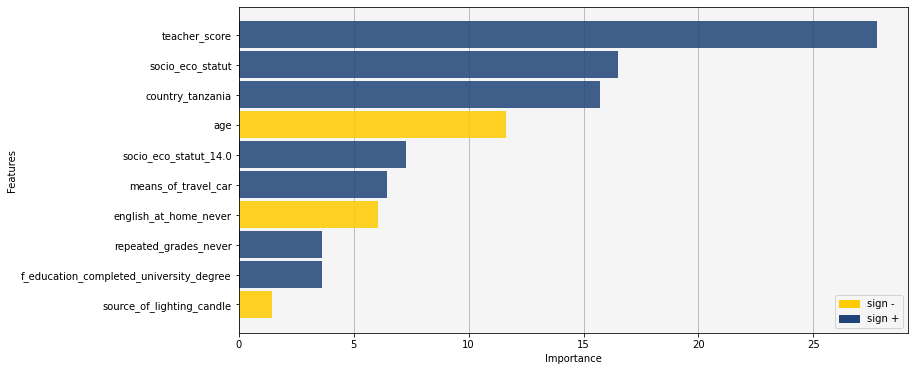

In [25]:
model = LinearRegression("africa_lr", solver = "BFGS")
model.drop()
model.fit(input_relation = "africa_clean",
          X = africa.get_columns(exclude_columns = ["student_score"]),
          y = "student_score")
x = model.features_importance()

We can clearly see the factors which influence the student score.
 - Having a Good Teacher leads to better results
 - Having a good socio economical statut leads to better results
 - Tanzania teachers are over-rating their students
 - Older Students have worst results than the youngest
 - Students going to school by car tend to have better results

Let's add the prediction to the vDataFrame to see how the model is doing the estimation.

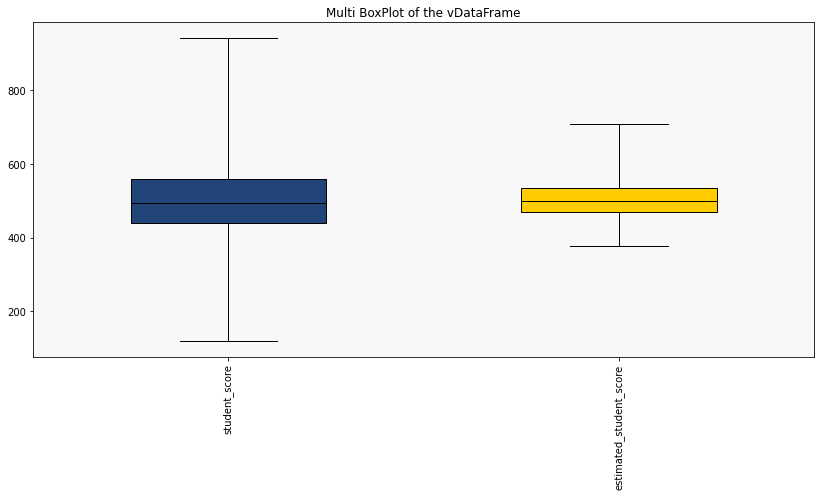

,student_score,socio_eco_statut,teacher_score,socio_eco_statut_14.0,means_of_travel_CAR,english_at_home_NEVER,repeated_grades_NEVER,age,country_Tanzania,source_of_lighting_CANDLE,f_education_Completed_University_Degree,estimated_student_score
0,425.993367323877,-0.6243597475136532,-3.186510348343,-0.17498274897769814,-0.23504366914916974,-0.4879838120935736,0.8049325972046161,0.393744054893519,-0.2854541713994659,-0.5224909511938355,-0.2640354330625033,439.889506489967
1,534.329515370892,-0.038169526015216546,-3.186510348343,-0.17498274897769814,-0.23504366914916974,-0.4879838120935736,0.8049325972046161,-0.20648359548582068,-0.2854541713994659,-0.5224909511938355,-0.2640354330625033,455.229769904805
2,536.690743411639,0.25492558473400173,-3.186510348343,-0.17498274897769814,-0.23504366914916974,-0.4879838120935736,0.8049325972046161,-0.8067112458651603,-0.2854541713994659,-0.5224909511938355,-0.2640354330625033,464.624978753079
3,569.392927563969,0.5480206954832201,-3.186510348343,-0.17498274897769814,-0.23504366914916974,-0.4879838120935736,0.8049325972046161,-0.20648359548582068,-0.2854541713994659,-0.5224909511938355,-0.2640354330625033,467.119879037933
4,542.037992351316,1.1342109169816565,-3.186510348343,-0.17498274897769814,-0.23504366914916974,-0.4879838120935736,0.8049325972046161,-0.8067112458651603,-0.2854541713994659,-0.5224909511938355,-0.2640354330625033,482.46014245277
,...,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: africa_education, Number of rows: 51801, Number of columns: 12

In [26]:
model.predict(africa, name = "estimated_student_score")
africa.boxplot(["estimated_student_score", "student_score"])

Very good and very bad students are hard to predict which make sense. Having advantages lead to better results but final results are still a matter of human behavior.

In [27]:
africa.describe(columns = ["student_score", "estimated_student_score"])

,count,mean,std,min,25%,50%,75%,max,unique
student_score,51801,504.058818080046,86.6049247718847,117.532999839887,440.399371291184,493.341623606933,558.423904717641,943.673770012441,3139.0
estimated_student_score,51801,504.052341948916,48.3916436050843,375.712246493153,469.323231283479,498.057815647673,533.400343124974,708.097032898996,40511.0


<object>

We can also notice that the student estimated score and the real score are following a normal distribution.

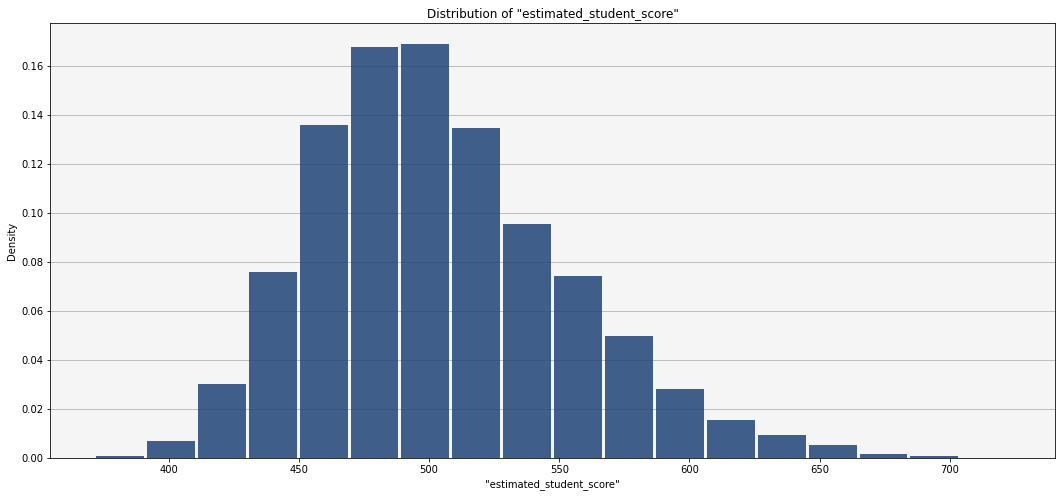

We test the following hypothesis:
(H0) The distribution of "estimated_student_score" is not normal
(H1) The distribution of "estimated_student_score" is normal
👍 - The distribution of "estimated_student_score" might be normal
jb = 3260.55103616831
p_value = 0.0


(True, 3260.55103616831, 0.0)

In [32]:
africa["estimated_student_score"].hist()
africa.testjb("estimated_student_score")

# Example using Decomposition

Let's now use decomposition techniques to only keep valuable information. When using these types of methods, there is no need to normalize or to look at the most correlated features. 

First let's repeat the data preparation process of the previous section and export the obtained vDataFrame to the Vertica DataBase.

In [1]:
from vertica_ml_python import *
africa = vDataFrame("africa_education")
africa = africa.select(["(zralocp + zmalocp) / 2 AS student_score",
                        "(zraloct + zmaloct) / 2 AS teacher_score",
                        "XNUMYRS AS teacher_year_teaching",
                        "numstu AS number_students_school",
                        "PENGLISH AS english_at_home",
                        "PTRAVEL AS travel_distance",
                        "PTRAVEL2 AS means_of_travel",
                        "PMOTHER AS m_education",
                        "PFATHER AS f_education",
                        "PLIGHT AS source_of_lighting",
                        "PABSENT AS days_absent",
                        "PREPEAT AS repeated_grades",
                        "zpsit AS sitting_place",
                        "PAGE AS age",
                        "zpses AS socio_eco_statut",
                        "country_long AS country"],
                        check = False)
africa.dropna()
africa.get_dummies(max_cardinality = 20)
africa.drop(columns = ["english_at_home",
                       "travel_distance",
                       "means_of_travel",
                       "m_education",
                       "f_education",
                       "source_of_lighting",
                       "repeated_grades",
                       "sitting_place",
                       "country"])
drop_table("africa_clean")
africa.to_db("africa_clean",
             relation_type = "table")

9089 element(s) was/were dropped
The table africa_clean was successfully dropped.


,student_score,teacher_score,teacher_year_teaching,number_students_school,days_absent,age,socio_eco_statut,english_at_home_ALL_THE_TIME,english_at_home_MOST_OF_THE_TIME,english_at_home_NEVER,travel_distance_>0.5-1KM,travel_distance_>1-1.5KM,travel_distance_>1.5-2KM,travel_distance_>2-2.5KM,travel_distance_>2.5-3KM,travel_distance_>3-3.5KM,travel_distance_>3.5-4KM,travel_distance_>4.5-5KM,travel_distance_>4KM-4.5KM,travel_distance_>5KM,means_of_travel_BICYCLE,means_of_travel_BUS_TRUCK_VAN,means_of_travel_CAR,means_of_travel_OTHER,means_of_travel_TRAIN,m_education_Completed_All_Primary,m_education_Completed_All_Secondary,m_education_Completed_Some_Primary,m_education_Completed_Some_Secondary,m_education_Completed_Some_University,m_education_Completed_Training_After_Secondary,m_education_Completed_University_Degree,m_education_I_Do_Not_Have_a_Mother,m_education_I_Do_Not_Know,m_education_No_School__No_Adult_Education,m_education_No_School__Some_Adult_Education,f_education_Completed_All_Primary,f_education_Completed_All_Secondary,f_education_Completed_Some_Primary,f_education_Completed_Some_Secondary,f_education_Completed_Some_University,f_education_Completed_Training_After_Secondary,f_education_Completed_University_Degree,f_education_I_Do_Not_Have_a_Father,f_education_I_Do_Not_Know,f_education_No_School__No_Adult_Education,f_education_No_School__Some_Adult_Education,source_of_lighting_CANDLE,source_of_lighting_ELECTRIC,source_of_lighting_FIRE,source_of_lighting_GAS,source_of_lighting_NO_LIGHTING,repeated_grades_NEVER,repeated_grades_ONCE,repeated_grades_THREE_PLUS,sitting_place_I_have_my_own_sitting_place,age_10,age_11,age_12,age_13,age_14,age_15,age_16,age_17,age_18,age_19,age_20,age_21,age_22,age_23,age_24,age_25,socio_eco_statut_1.0,socio_eco_statut_2.0,socio_eco_statut_3.0,socio_eco_statut_4.0,socio_eco_statut_5.0,socio_eco_statut_6.0,socio_eco_statut_7.0,socio_eco_statut_8.0,socio_eco_statut_9.0,socio_eco_statut_10.0,socio_eco_statut_11.0,socio_eco_statut_12.0,socio_eco_statut_13.0,socio_eco_statut_14.0,country_Botswana,country_Kenya,country_Lesotho,country_Malawi,country_Mozambique,country_Namibia,country_Seychelles,country_South_Africa,country_Swaziland,country_Tanzania,country_Uganda,country_Zambia,country_Zanzibar
0,425.993367323877,537.289572911762,10.0,23,0,14,5.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,534.329515370892,537.289572911762,10.0,23,0,13,7.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,536.690743411639,537.289572911762,10.0,23,0,12,8.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,569.392927563969,537.289572911762,10.0,23,0,13,9.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,542.037992351316,537.289572911762,10.0,23,0,12,11.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: africa_education, Number of rows: 51801, Number of columns: 99

Let's create our PCA model.

In [8]:
from vertica_ml_python.learn.decomposition import PCA
model = PCA(name = "africa_pca")
model.drop()
model.fit("africa_clean",
          africa.get_columns(exclude_columns = ["student_score"]))
pca = model.to_vdf(key_columns = africa.get_columns(exclude_columns = ["student_score"]))
africa_pca = africa.join(pca,
                         how = "natural",
                         expr1 = ["student_score"],
                         expr2 = ["col{}".format(i) for i in range(1, 97)])
print(africa_pca)

,student_score,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20,col21,col22,col23,col24,col25,col26,col27,col28,col29,col30,col31,col32,col33,col34,col35,col36,col37,col38,col39,col40,col41,col42,col43,col44,col45,col46,col47,col48,col49,col50,col51,col52,col53,col54,col55,col56,col57,col58,col59,col60,col61,col62,col63,col64,col65,col66,col67,col68,col69,col70,col71,col72,col73,col74,col75,col76,col77,col78,col79,col80,col81,col82,col83,col84,col85,col86,col87,col88,col89,col90,col91,col92,col93,col94,col95,col96
0,425.993367323877,-232.099469763724,4.22179800325107,-2.62059403132317,-0.112339086413151,-1.65733853864577,0.0100386044753876,0.379231702307265,-0.317016981578339,-0.0975096929776668,0.223072512336501,-0.0232257381269176,1.21894950543791,0.251358040323548,-0.747937522894407,0.216739587247289,0.34648551275727,0.304961496556422,0.398992098274571,0.224513440783831,-0.449298326533813,-0.221117116432335,-0.52726049662796,0.836959130160652,-0.0540358870410155,-0.0994204273073724,-0.392395594184426,0.339424922000356,-0.189154106285486,0.163451657089035,0.0408684511307475,-0.0572062233650183,0.086404614254716,-0.141938224080764,-0.0791785082135564,0.0475847503718787,-0.168830472186994,0.0568432835934505,-0.0482437000158492,0.148139595374633,-0.104062059113656,0.166604017331558,0.00709281260323807,-0.0933279503075716,-0.0896872340526757,-0.156299516247453,-0.194989732065114,-0.10029065987828,-0.0311679421511638,0.0883105715648863,-0.0948041454019282,0.150315783213366,0.0629880983874312,-0.0718419918900692,-0.248682999543852,0.0902567870628775,0.0666817498736203,-0.127307065574117,0.055598030497722,0.0324453997039365,0.0338580969288461,-0.717414707348172,-0.339404237567712,0.215005886087157,0.283595680453906,-0.2371590715699,-0.0990151901705911,-0.0299348685573657,0.0319899098132933,0.024882004351086,0.0433369561549505,-0.0957099515178369,-0.173250503093347,0.00101541602539153,0.101851195804588,0.0343455201300341,0.0194961080592518,-0.0134344317645887,0.164697751365543,-0.0167061188910645,0.0847467164719844,-0.0334225312222623,0.00660416092546774,-0.0122070044931245,0.0224581443075931,-0.00907173728920302,-0.0408687807957008,0.00248446789989588,0.00104749027851748,-0.00930586470925036,-0.00296106934099194,-4.48723962417767E-4,-3.04962641380696E-4,-2.0984972503978E-4,5.80741190440598E-4,2.25803645642054E-4,-6.83411479473665E-5
1,534.329515370892,-232.081064153653,4.4023808288576,-2.49069251413335,2.03479004837712,-1.09870958610809,-0.555841133449485,0.20753107260559,0.554666736987913,0.619924027722584,-0.311501149309674,-0.0510008416546766,-0.475177886891351,0.203672834845762,-0.163677872346232,0.840310035523494,0.196790864586984,0.110160110670007,0.145138238614992,0.606089088491876,-0.862357468105414,-0.20063262787939,0.682397920837503,0.271981209445305,0.552694784111001,0.166106314916484,0.508273233610753,0.547176654440302,-0.0182161869200158,0.0119078958723979,-0.508001227619992,-0.178642502301127,-0.391110239974669,-0.266144059677509,-0.00566203041090909,0.302436378687653,-0.145599284621021,-0.144299268868615,-0.113391441126886,0.170537636242761,0.0809512565244836,0.0577341994571061,-0.10760097071607,0.0806131714434741,0.0756168553059724,0.0801347199656453,-0.171924239797574,0.0777847003477066,0.0686745005730984,-0.0472478642986694,-0.011137648848924,0.0541125796770197,-0.141567554818099,-0.0464209887919685,0.0496334758345093,0.0201924904464776,-0.038001600220646,0.0296451170736681,0.0212512031820593,-0.0162390562511898,0.0415986534671987,0.00638676317773243,-0.030353941086713,0.12861120888485,0.00818289231113528,0.00296999713011966,0.0616198353248337,-0.0180434188571847,-0.0142175124928541,0.00511959717565051,-0.00987018572402148,-0.165457833374571,-0.0117290690260257,-0.0203827041049504,0.0540603345144691,0.0127234419082427,0.0094672190231402,-0.00472772054675294,0.0389198105350945,-0.00367268380586707,0.0516131185414096,0.00188114976918333,-0.004195224206994

<object>  Name: join, Number of rows: 52629, Number of columns: 97


Thanks to PCA, all the components will verify the Gauss Markov hypotheses.

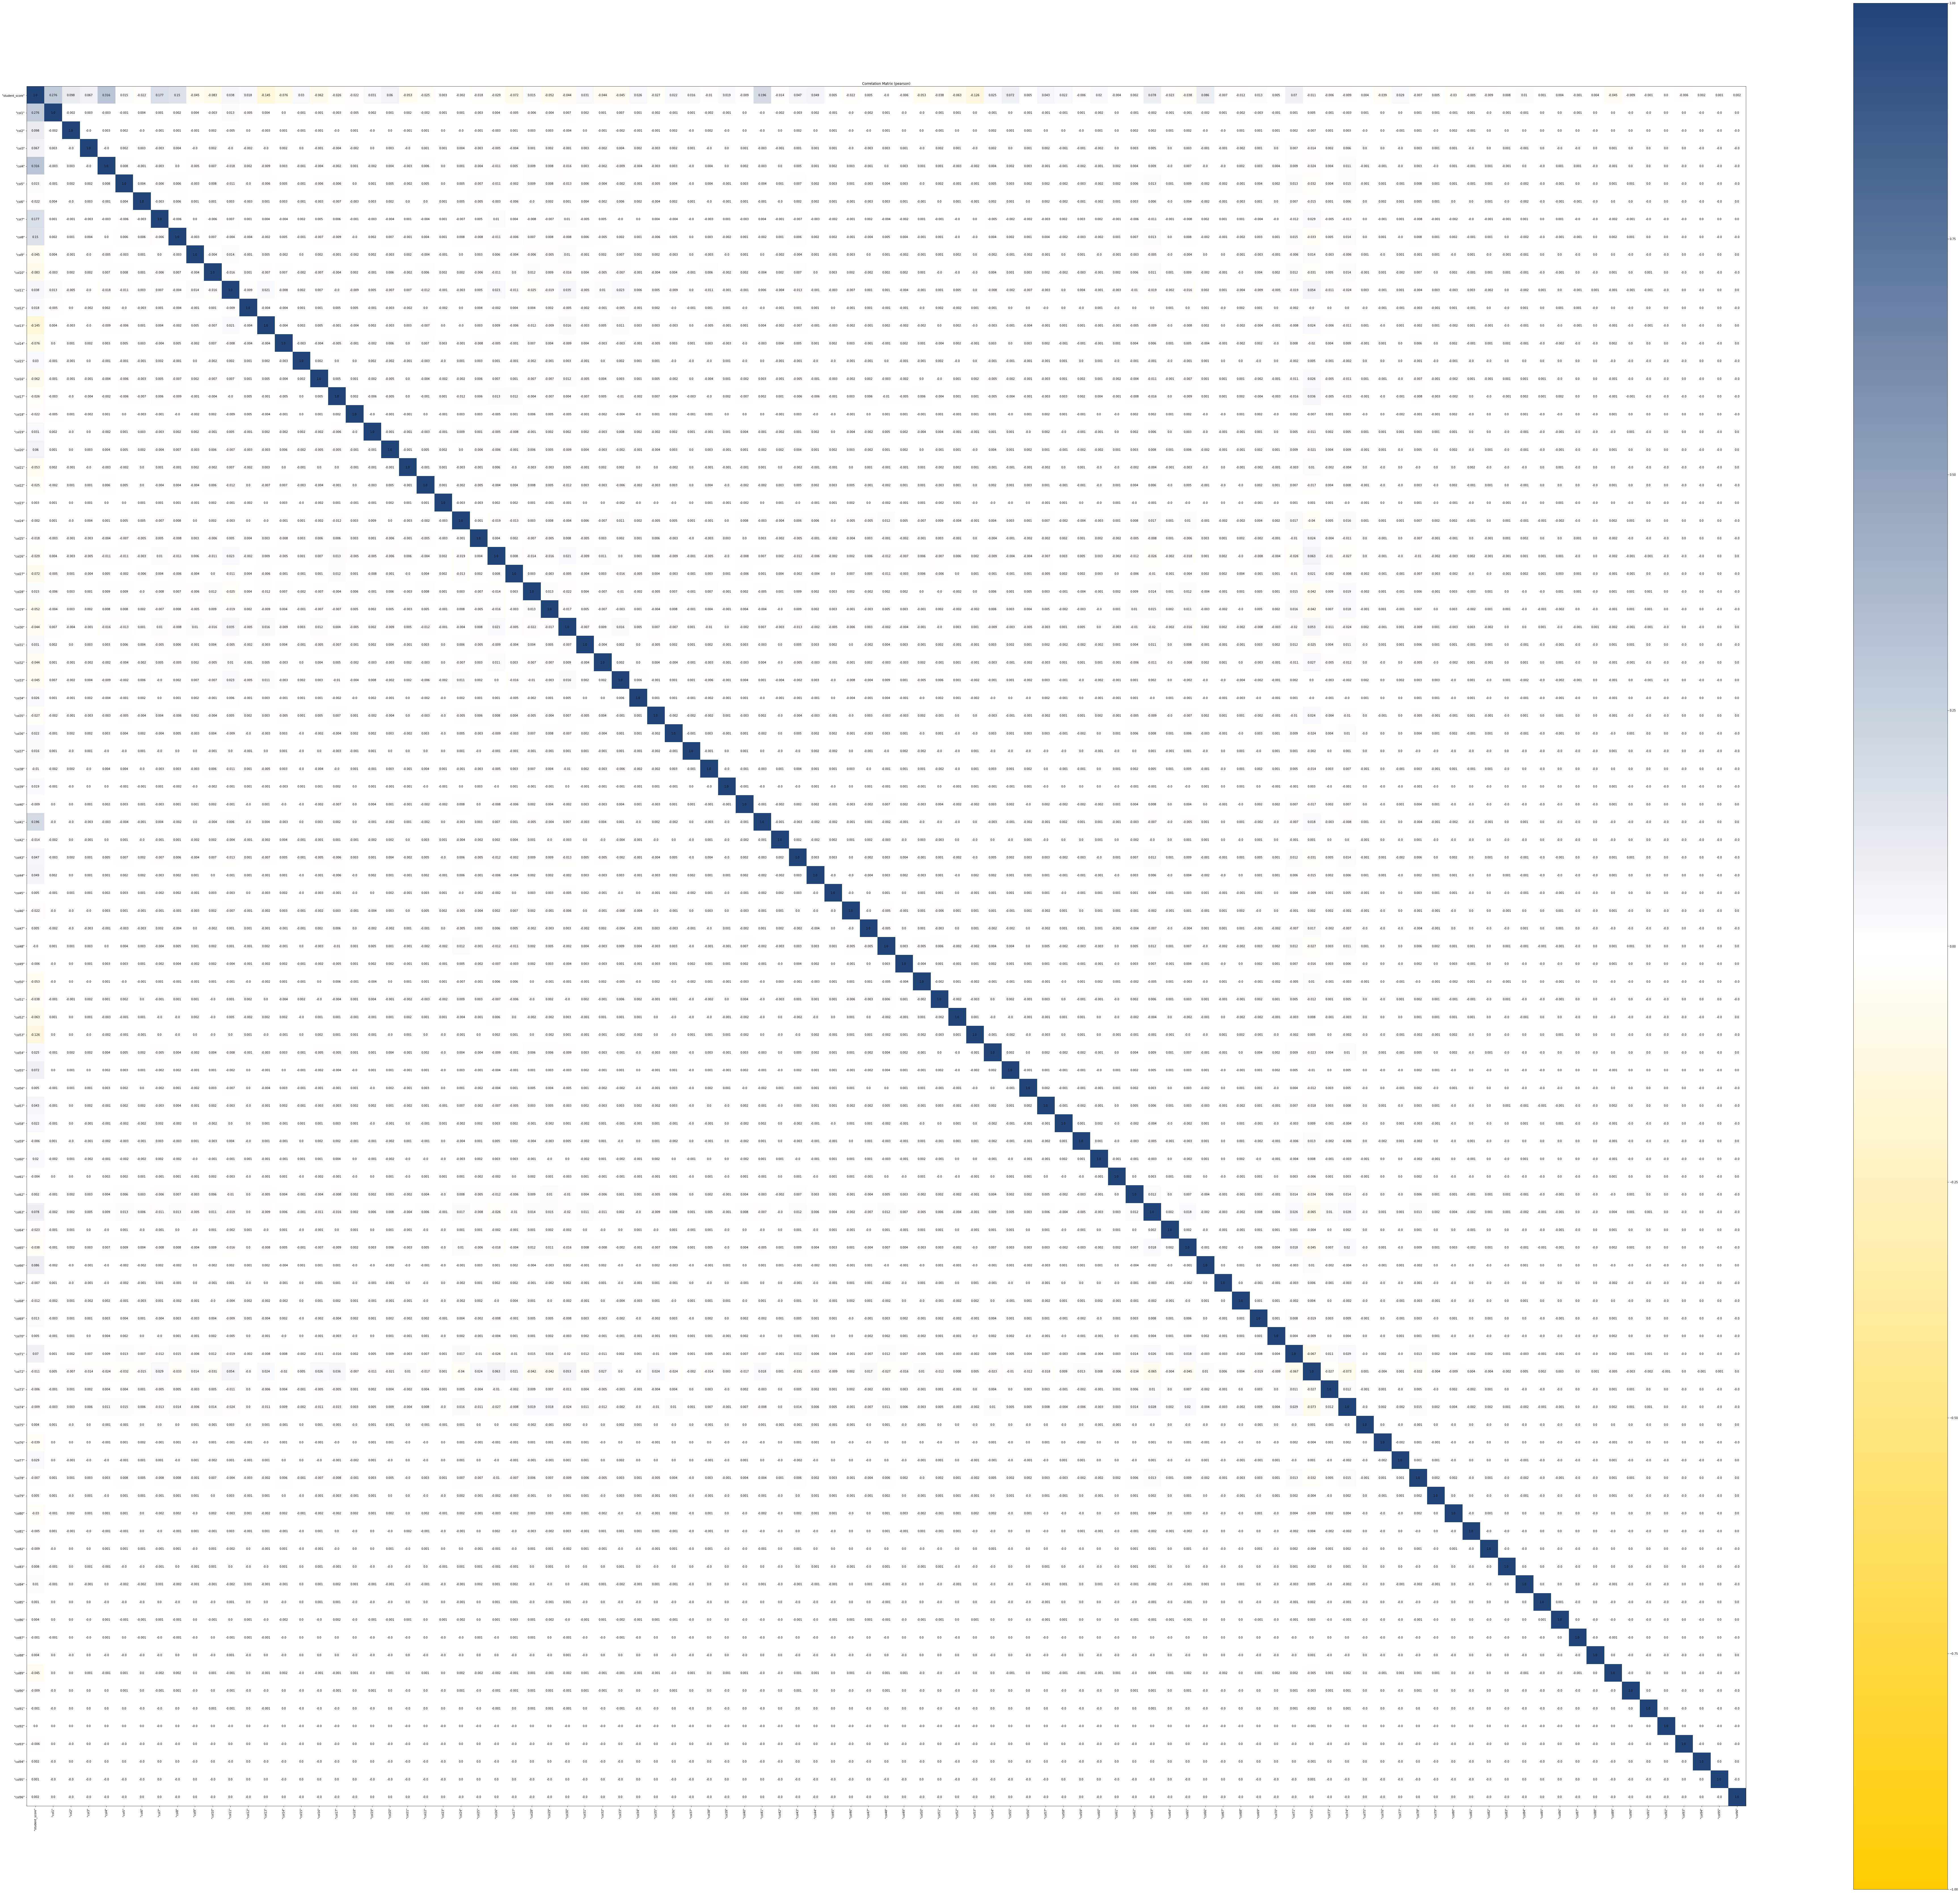

In [10]:
x = africa_pca.corr()

Let's export the result to the Vertica DataBase.

In [11]:
africa_pca.to_db("africa_clean_pca",
                 relation_type = "table")

,student_score,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20,col21,col22,col23,col24,col25,col26,col27,col28,col29,col30,col31,col32,col33,col34,col35,col36,col37,col38,col39,col40,col41,col42,col43,col44,col45,col46,col47,col48,col49,col50,col51,col52,col53,col54,col55,col56,col57,col58,col59,col60,col61,col62,col63,col64,col65,col66,col67,col68,col69,col70,col71,col72,col73,col74,col75,col76,col77,col78,col79,col80,col81,col82,col83,col84,col85,col86,col87,col88,col89,col90,col91,col92,col93,col94,col95,col96
0,425.993367323877,-232.099469763724,4.22179800325107,-2.62059403132317,-0.112339086413151,-1.65733853864577,0.0100386044753876,0.379231702307265,-0.317016981578339,-0.0975096929776668,0.223072512336501,-0.0232257381269176,1.21894950543791,0.251358040323548,-0.747937522894407,0.216739587247289,0.34648551275727,0.304961496556422,0.398992098274571,0.224513440783831,-0.449298326533813,-0.221117116432335,-0.52726049662796,0.836959130160652,-0.0540358870410155,-0.0994204273073724,-0.392395594184426,0.339424922000356,-0.189154106285486,0.163451657089035,0.0408684511307475,-0.0572062233650183,0.086404614254716,-0.141938224080764,-0.0791785082135564,0.0475847503718787,-0.168830472186994,0.0568432835934505,-0.0482437000158492,0.148139595374633,-0.104062059113656,0.166604017331558,0.00709281260323807,-0.0933279503075716,-0.0896872340526757,-0.156299516247453,-0.194989732065114,-0.10029065987828,-0.0311679421511638,0.0883105715648863,-0.0948041454019282,0.150315783213366,0.0629880983874312,-0.0718419918900692,-0.248682999543852,0.0902567870628775,0.0666817498736203,-0.127307065574117,0.055598030497722,0.0324453997039365,0.0338580969288461,-0.717414707348172,-0.339404237567712,0.215005886087157,0.283595680453906,-0.2371590715699,-0.0990151901705911,-0.0299348685573657,0.0319899098132933,0.024882004351086,0.0433369561549505,-0.0957099515178369,-0.173250503093347,0.00101541602539153,0.101851195804588,0.0343455201300341,0.0194961080592518,-0.0134344317645887,0.164697751365543,-0.0167061188910645,0.0847467164719844,-0.0334225312222623,0.00660416092546774,-0.0122070044931245,0.0224581443075931,-0.00907173728920302,-0.0408687807957008,0.00248446789989588,0.00104749027851748,-0.00930586470925036,-0.00296106934099194,-4.48723962417767E-4,-3.04962641380696E-4,-2.0984972503978E-4,5.80741190440598E-4,2.25803645642054E-4,-6.83411479473665E-5
1,534.329515370892,-232.081064153653,4.4023808288576,-2.49069251413335,2.03479004837712,-1.09870958610809,-0.555841133449485,0.20753107260559,0.554666736987913,0.619924027722584,-0.311501149309674,-0.0510008416546766,-0.475177886891351,0.203672834845762,-0.163677872346232,0.840310035523494,0.196790864586984,0.110160110670007,0.145138238614992,0.606089088491876,-0.862357468105414,-0.20063262787939,0.682397920837503,0.271981209445305,0.552694784111001,0.166106314916484,0.508273233610753,0.547176654440302,-0.0182161869200158,0.0119078958723979,-0.508001227619992,-0.178642502301127,-0.391110239974669,-0.266144059677509,-0.00566203041090909,0.302436378687653,-0.145599284621021,-0.144299268868615,-0.113391441126886,0.170537636242761,0.0809512565244836,0.0577341994571061,-0.10760097071607,0.0806131714434741,0.0756168553059724,0.0801347199656453,-0.171924239797574,0.0777847003477066,0.0686745005730984,-0.0472478642986694,-0.011137648848924,0.0541125796770197,-0.141567554818099,-0.0464209887919685,0.0496334758345093,0.0201924904464776,-0.038001600220646,0.0296451170736681,0.0212512031820593,-0.0162390562511898,0.0415986534671987,0.00638676317773243,-0.030353941086713,0.12861120888485,0.00818289231113528,0.00296999713011966,0.0616198353248337,-0.0180434188571847,-0.0142175124928541,0.00511959717565051,-0.00987018572402148,-0.165457833374571,-0.0117290690260257,-0.0203827041049504,0.0540603345144691,0.0127234419082427,0.0094672190231402,-0.00472772054675294,0.0389198105350945,-0.00367268380586707,0.0516131185414096,0.00188114976918333,-0.004195224206994

<object>  Name: join, Number of rows: 52629, Number of columns: 97

Let's do a Cross Validation to test our Linear Regression model.

In [12]:
from vertica_ml_python.learn.linear_model import LinearRegression
from vertica_ml_python.learn.model_selection import cross_validate
cross_validate(LinearRegression("africa_lr", solver = "BFGS"), 
               input_relation = "africa_clean_pca",
               X = africa_pca.get_columns(exclude_columns = ["student_score"]),
               y = "student_score")

,explained_variance,max_error,median_absolute_error,mean_absolute_error,mean_squared_error,r2
1-fold,0.403850754099576,379.352573522969,42.5212723770283,52.134532049895,4483.33115827966,0.403785929532344
2-fold,0.41444643083861,350.548714287835,41.9002390311532,51.5232519152336,4411.23457330699,0.414402487034732
3-fold,0.41964455263038,368.029803314475,42.0147851600058,51.4047547402191,4367.26199023722,0.419642834973648
avg,0.41264724585618867,365.977030375093,42.14543218939577,51.68751290178257,4420.609240607956,0.41261041718024133
std,0.008049150138904998,14.511236482975788,0.3304876531559449,0.3916375674089236,58.599711882985304,0.008078923091362173


<object>

The model is even better than the first technique !

# Conclusion

We saw two techniques which can help us when creating Linear Regression models. The first one uses normalization and filters whereas the second one applies a PCA model. Both of them allow us to follow the Gauss Markov hypotheses which are essential when dealing with this algorithm.